In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error

Path('outputs').mkdir(exist_ok=True)

# funções métricas robustas
def mae(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    return (dfm.iloc[:,0] - dfm.iloc[:,1]).abs().mean()

def rmse(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    return np.sqrt(((dfm.iloc[:,0] - dfm.iloc[:,1])**2).mean())

def mape(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    dfm = dfm[dfm.iloc[:,0] != 0]
    return (dfm.iloc[:,0].sub(dfm.iloc[:,1]).abs().div(dfm.iloc[:,0]).mean()) * 100


In [4]:
# tenta carregar CSV local, senão baixa do Yahoo
csv_path = Path('data/btc_limpo.csv')

if csv_path.exists():
    df.index = pd.to_datetime(df.index)
    print('Carregado de', csv_path)
else:
    import yfinance as yf
    df = yf.download('BTC-USD', start='2016-01-01', end=None)
    print('Baixado via yfinance')

# Se houver MultiIndex nas colunas, achata
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join([str(x) for x in col if str(x) and str(x) != '']).strip() for col in df.columns]

# normaliza nomes (remove espaços)
df.columns = [c.strip() for c in df.columns]

# mostra colunas e primeiras linhas para você confirmar
print('Colunas detectadas:', df.columns.tolist())
display(df.head())


Carregado de data\btc_limpo.csv
Colunas detectadas: ['Close', 'Hight', 'Low', 'Open', 'Volume']


,Close,Hight,Low,Open,Volume
Date,,,,,
2020-06-01,10167.268555,10199.565430,9450.899414,9463.605469,35198901068
2020-06-02,9529.803711,10182.340820,9460.571289,10162.973633,39137252109
2020-06-03,9656.717773,9682.859375,9471.846680,9533.760742,25007459262
2020-06-04,9800.636719,9887.610352,9525.247070,9655.854492,25921805072
2020-06-05,9665.533203,9869.237305,9663.216797,9800.215820,23509628646


In [5]:
# identificar o nome da coluna de fechamento (Close)
close_candidates = [c for c in df.columns if 'close' in c.lower()]
if len(close_candidates) == 0:
    raise ValueError('Não foi encontrada coluna de fechamento. Verifique df.columns.')
close_col = close_candidates[0]
print('Usando coluna de fechamento:', close_col)

# série de preço e limpeza
series = pd.to_numeric(df[close_col], errors='coerce').dropna()
series.index = pd.to_datetime(series.index)
series = series.sort_index()

# garantir frequência diária (para evitar warnings) e ffill lacunas curtas
series = series.asfreq('D')
series = series.ffill()

print('Série pronta:', series.index.min(), '→', series.index.max(), '| pontos:', len(series))
series.tail()


Usando coluna de fechamento: Close
Série pronta: 2020-06-01 00:00:00 → 2025-05-31 00:00:00 | pontos: 1826


Date
2025-05-27    108994.640625
2025-05-28    107802.328125
2025-05-29    105641.757812
2025-05-30    103998.570312
2025-05-31    104638.093750
Freq: D, Name: Close, dtype: float64

In [6]:
split = int(len(series) * 0.8)
train = series.iloc[:split].copy()
test  = series.iloc[split:].copy()

print('Treino:', train.index.min(), '→', train.index.max(), '| n =', len(train))
print('Teste :', test.index.min(), '→', test.index.max(),  '| n =', len(test))


Treino: 2020-06-01 00:00:00 → 2024-05-30 00:00:00 | n = 1460
Teste : 2024-05-31 00:00:00 → 2025-05-31 00:00:00 | n = 366


In [7]:
pred_naive = series.shift(1).loc[test.index]
pred_snaive7 = series.shift(7).loc[test.index]

df_preds = pd.DataFrame({
    'Real': test,
    'Naive': pred_naive,
    'SNaive7': pred_snaive7
})
df_preds.to_csv('outputs/predictions_baselines.csv')
print('Baselines salvos em outputs/predictions_baselines.csv')
display(df_preds.head())


Baselines salvos em outputs/predictions_baselines.csv


,Real,Naive,SNaive7
Date,,,
2024-05-31,67491.414062,68364.992188,68526.101562
2024-06-01,67706.937500,67491.414062,69265.945312
2024-06-02,67751.601562,67706.937500,68518.093750
2024-06-03,68804.781250,67751.601562,69394.554688
2024-06-04,70567.765625,68804.781250,68296.218750


In [8]:
from statsmodels.tsa.arima.model import ARIMA

order = (5,1,2)
model = ARIMA(train, order=order)
res = model.fit()
pred_arima = res.forecast(steps=len(test))
pred_arima.index = test.index

df_preds['ARIMA_512'] = pred_arima
df_preds.to_csv('outputs/predictions_with_arima_512.csv')
print('ARIMA(5,1,2) salvo em outputs/predictions_with_arima_512.csv')
display(df_preds.tail())


ARIMA(5,1,2) salvo em outputs/predictions_with_arima_512.csv


,Real,Naive,SNaive7,ARIMA_512
Date,,,,
2025-05-27,108994.640625,109440.367188,106791.085938,68265.603838
2025-05-28,107802.328125,108994.640625,109678.078125,68265.603838
2025-05-29,105641.757812,107802.328125,111673.281250,68265.603838
2025-05-30,103998.570312,105641.757812,107287.796875,68265.603838
2025-05-31,104638.093750,103998.570312,107791.156250,68265.603838


In [9]:
# roda walk-forward apenas para últimos N dias do teste para poupar tempo
max_wf_days = min(len(test), 180)  # ajuste: 180 dias de rolling para não travar
start_idx = len(test) - max_wf_days
history = list(train.values)
wf_preds = [np.nan] * (len(test) - max_wf_days)

for i in range(max_wf_days):
    t = start_idx + i
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    wf_preds.append(yhat)
    history.append(test.iloc[t])

pred_arima_wf = pd.Series(wf_preds, index=test.index)
df_preds['ARIMA_wf'] = pred_arima_wf
df_preds.to_csv('outputs/predictions_with_arima_wf.csv')
print('ARIMA walk-forward (parcial) salvo em outputs/predictions_with_arima_wf.csv')
display(df_preds.tail())


C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

KeyboardInterrupt: 

In [10]:
from statsmodels.tsa.arima.model import ARIMA

history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])  # atualiza com o valor real


C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In [11]:
# montar features simples para regressão: lag1 e lag7
df_lr = pd.DataFrame({'Close': series})
df_lr['lag1'] = df_lr['Close'].shift(1)
df_lr['lag7'] = df_lr['Close'].shift(7)
df_lr = df_lr.dropna()

# split com mesmas datas (alinha índices)
split_idx = int(len(df_lr) * 0.8)
train_lr = df_lr.iloc[:split_idx]
test_lr  = df_lr.iloc[split_idx:]

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X_train = train_lr[['lag1','lag7']].values
y_train = train_lr['Close'].values
X_test  = test_lr[['lag1','lag7']].values
y_test  = test_lr['Close'].values

lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
pred_lr_series = pd.Series(pred_lr, index=test_lr.index)

# inserir no df_preds (reindex com índice do teste original)
pred_lr_aligned = pred_lr_series.reindex(test.index)
df_preds['LinearRegression'] = pred_lr_aligned
df_preds.to_csv('outputs/predictions_with_lr.csv')
print('Regressão Linear salva em outputs/predictions_with_lr.csv')
display(df_preds.tail())


Regressão Linear salva em outputs/predictions_with_lr.csv


,Real,Naive,SNaive7,ARIMA_512,LinearRegression
Date,,,,,
2025-05-27,108994.640625,109440.367188,106791.085938,68265.603838,109294.256087
2025-05-28,107802.328125,108994.640625,109678.078125,68265.603838,108828.613194
2025-05-29,105641.757812,107802.328125,111673.281250,68265.603838,107619.300519
2025-05-30,103998.570312,105641.757812,107287.796875,68265.603838,105478.599744
2025-05-31,104638.093750,103998.570312,107791.156250,68265.603838,103826.210913


In [12]:
models = [c for c in ['Naive','SNaive7','ARIMA_512','ARIMA_wf','LinearRegression'] if c in df_preds.columns]
rows = []
for m in models:
    rows.append({
        'model': m,
        'MAE': mae(df_preds['Real'], df_preds[m]),
        'RMSE': rmse(df_preds['Real'], df_preds[m]),
        'MAPE(%)': mape(df_preds['Real'], df_preds[m])
    })

metrics_df = pd.DataFrame(rows).set_index('model').sort_values('MAPE(%)')
metrics_df.to_csv('outputs/metrics_comparison_1112.csv')
print('Métricas salvas em outputs/metrics_comparison_1112.csv')
display(metrics_df.round(6))


Métricas salvas em outputs/metrics_comparison_1112.csv


,MAE,RMSE,MAPE(%)
model,,,
Naive,1479.306886,2082.829296,1.853545
LinearRegression,1489.877212,2094.426885,1.864137
SNaive7,3853.281314,5067.353510,4.878077
ARIMA_512,17089.917350,20954.706003,19.262982


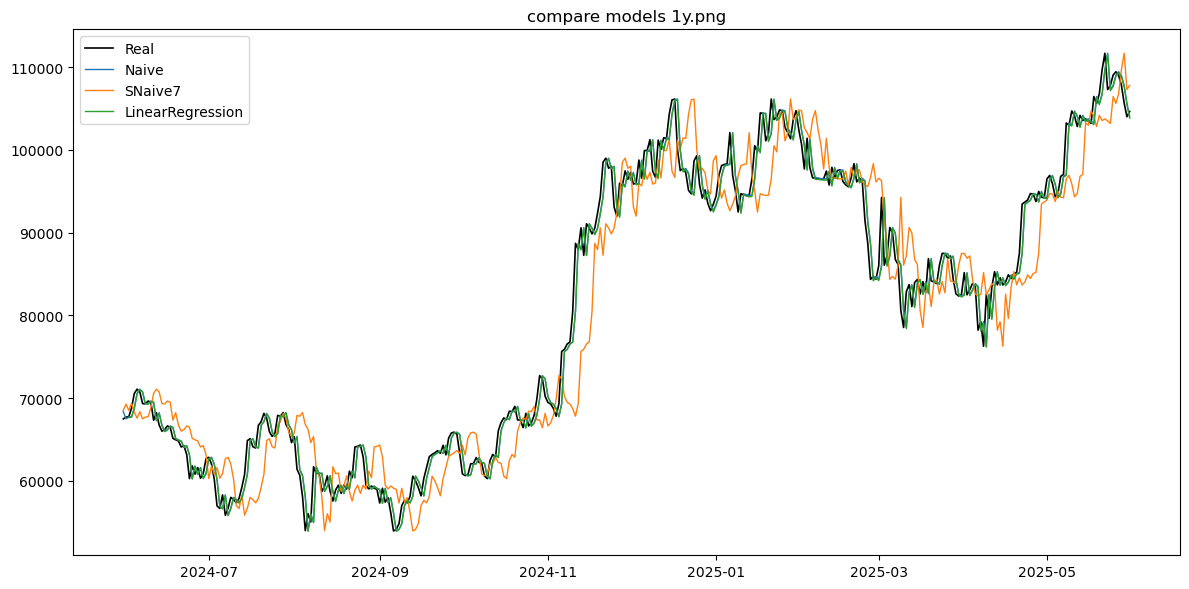

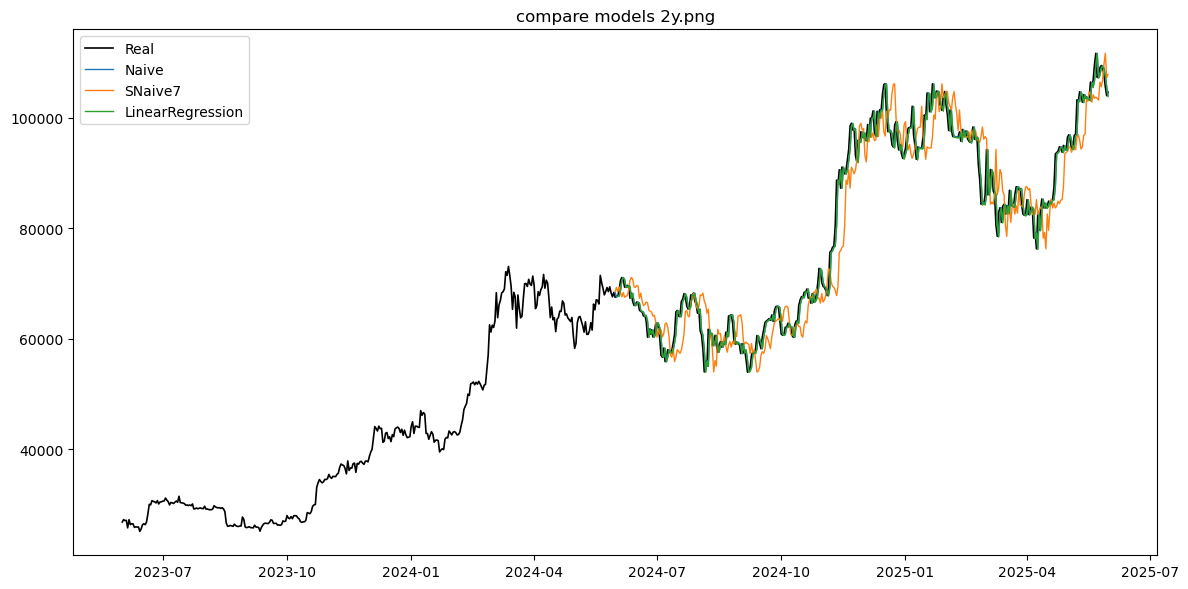

Gráficos salvos em outputs/


In [14]:
def plot_and_save(series, preds_df, fname, days=365):
    end = series.index.max()
    start = end - pd.Timedelta(days=days)
    plt.figure(figsize=(12,6))
    plt.plot(series[start:].index, series[start:].values, label='Real', linewidth=1.2, color='black')
    for col in preds_df.columns:
        p = preds_df[col].reindex(series[start:].index)
        if p.isna().all():
            continue
        plt.plot(p.index, p.values, label=col, linewidth=1)
    plt.title(fname.replace('_',' '))
    plt.legend()
    plt.tight_layout()
    plt.savefig('outputs/' + fname, dpi=150)
    plt.show()

# ajuste só para os modelos que você realmente tem no df_preds
plot_and_save(series, df_preds[['Naive','SNaive7','LinearRegression']], 'compare_models_1y.png', days=365)

plot_and_save(series, df_preds[['Naive','SNaive7','LinearRegression']], 'compare_models_2y.png', days=730)

print('Gráficos salvos em outputs/')


In [15]:
# salva previsões completas
df_preds.to_csv('outputs/predictions_all_models_1112.csv')

# metrics_df já criado; gerar resumo text
with open('outputs/resumo_para_notion_1112.txt', 'w', encoding='utf-8') as fh:
    fh.write('Resumo de resultados - 11/09\n\n')
    fh.write('Período de dados: {} -> {}\n\n'.format(series.index.min().date(), series.index.max().date()))
    fh.write('Métricas (ordenadas por MAPE):\n')
    for idx, row in metrics_df.iterrows():
        fh.write(f'- {idx}: MAE={row["MAE"]:.2f}, RMSE={row["RMSE"]:.2f}, MAPE={row["MAPE(%)"]:.2f}%\n')
    fh.write('\nObservações rápidas:\n')
    fh.write('- Naive e Regressão Linear parecem muito competitivos; confirme MAPE.\n')
    fh.write('- SNaive7 tende a apresentar defasagem; isso é esperado.\n')
    fh.write('- ARIMA(5,1,2) (estático) foi rodado; compare MAPE para decidir se vale aprofundar.\n')

print('Arquivos salvo: outputs/predictions_all_models_1112.csv e outputs/resumo_para_notion_1112.txt')


Arquivos salvo: outputs/predictions_all_models_1112.csv e outputs/resumo_para_notion_1112.txt
